In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset, transforms and visualisition

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

0it [00:00, ?it/s]

100%|█████████▉| 170319872/170498071 [00:20<00:00, 10103758.52it/s]

Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels.size(0))

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
4


In [0]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

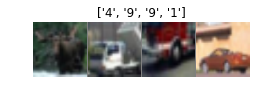

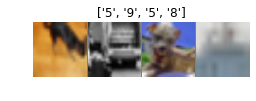

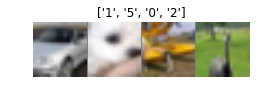

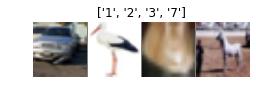

In [11]:
for i in range(4):
  show_batch_images(trainloader)

# Creating VGG-16

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn()

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [15]:
print(vgg.features[1])

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [16]:
print(vgg.classifier[2])

Dropout(p=0.5)


In [17]:
# change out features in in_built vgg model (1000 -> 10)
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=10, bias=True)]


In [18]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


# Train CIFAR10

In [0]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [25]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
    if i % 100 == 0:
      print('Iteration : %d/%d, Loss : %0.2f' % (i, n_iters, loss.item()))
            
  loss_epoch_arr.append(loss.item())
  print('Epoch : %d/%d, Train accuracy : %0.2f, Test accuracy : %0.2f' % (epoch, max_epochs, evaluation(trainloader, vgg), evaluation(testloader, vgg)))
  
plt.plot(loss_epoch_arr)
plt.show()

Iteration : 0/3125, Loss : 2.65
Iteration : 100/3125, Loss : 2.29
Iteration : 200/3125, Loss : 2.12
Iteration : 300/3125, Loss : 2.27
Iteration : 400/3125, Loss : 2.16
Iteration : 500/3125, Loss : 2.38
Iteration : 600/3125, Loss : 2.04
Iteration : 700/3125, Loss : 2.15
Iteration : 800/3125, Loss : 2.10
Iteration : 900/3125, Loss : 1.93
Iteration : 1000/3125, Loss : 2.30
Iteration : 1100/3125, Loss : 1.96
Iteration : 1200/3125, Loss : 2.15
Iteration : 1300/3125, Loss : 2.06
Iteration : 1400/3125, Loss : 1.94
Iteration : 1500/3125, Loss : 1.77
Iteration : 1600/3125, Loss : 2.18
Iteration : 1700/3125, Loss : 1.91
Iteration : 1800/3125, Loss : 2.19
Iteration : 1900/3125, Loss : 2.14
Iteration : 2000/3125, Loss : 1.71
Iteration : 2100/3125, Loss : 1.86
Iteration : 2200/3125, Loss : 2.00
Iteration : 2300/3125, Loss : 2.13
Iteration : 2400/3125, Loss : 2.01
Iteration : 2500/3125, Loss : 1.83
Iteration : 2600/3125, Loss : 1.80
Iteration : 2700/3125, Loss : 1.98
Iteration : 2800/3125, Loss : 2.

KeyboardInterrupt: ignored

# Freeze layers of Convolutional Operations

In [0]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [27]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth

100%|██████████| 553507836/553507836 [00:03<00:00, 139449125.02it/s]

In [0]:
for param in vgg.parameters():
  param.requires_grad = False

In [0]:
fianl_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(fianl_in_features, num_classes)

In [40]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [42]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
    if i % 100 == 0:
      print('Iteration : %d/%d, Loss : %0.2f' % (i, n_iters, loss.item()))
            
  loss_epoch_arr.append(loss.item())
  print('Epoch : %d/%d, Train accuracy : %0.2f, Test accuracy : %0.2f' % (epoch, max_epochs, evaluation(trainloader, vgg), evaluation(testloader, vgg)))
  
plt.plot(loss_epoch_arr)
plt.show()

Iteration : 0/3125, Loss : 2.33
Iteration : 100/3125, Loss : 1.73
Iteration : 200/3125, Loss : 1.81
Iteration : 300/3125, Loss : 1.50
Iteration : 400/3125, Loss : 1.07
Iteration : 500/3125, Loss : 1.85
Iteration : 600/3125, Loss : 1.42
Iteration : 700/3125, Loss : 1.91
Iteration : 800/3125, Loss : 1.56
Iteration : 900/3125, Loss : 1.02
Iteration : 1000/3125, Loss : 2.37
Iteration : 1100/3125, Loss : 2.40
Iteration : 1200/3125, Loss : 2.28
Iteration : 1300/3125, Loss : 2.53
Iteration : 1400/3125, Loss : 2.65
Iteration : 1500/3125, Loss : 1.63
Iteration : 1600/3125, Loss : 1.17
Iteration : 1700/3125, Loss : 1.42
Iteration : 1800/3125, Loss : 2.85
Iteration : 1900/3125, Loss : 2.30
Iteration : 2000/3125, Loss : 1.57
Iteration : 2100/3125, Loss : 1.76
Iteration : 2200/3125, Loss : 3.50
Iteration : 2300/3125, Loss : 1.64
Iteration : 2400/3125, Loss : 2.34
Iteration : 2500/3125, Loss : 2.41
Iteration : 2600/3125, Loss : 2.73
Iteration : 2700/3125, Loss : 1.86
Iteration : 2800/3125, Loss : 1.

KeyboardInterrupt: ignored

# With Model Copy

In [0]:
import copy

In [45]:
loss_epoch_arr = []
max_epochs = 1
min_loss = 100

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min Loss : %0.2f' % min_loss)
    
    if i % 100 == 0:
      print('Iteration : %d/%d, Loss : %0.2f' % (i, n_iters, loss.item()))
            
  loss_epoch_arr.append(loss.item())
  print('Epoch : %d/%d, Train accuracy : %0.2f, Test accuracy : %0.2f' % (epoch, max_epochs, evaluation(trainloader, vgg), evaluation(testloader, vgg)))
  
plt.plot(loss_epoch_arr)
plt.show()

Min Loss : 2.32
Iteration : 0/3125, Loss : 2.32
Min Loss : 1.59
Min Loss : 1.09
Min Loss : 0.90
Min Loss : 0.74
Iteration : 100/3125, Loss : 2.43
Min Loss : 0.73
Min Loss : 0.66
Iteration : 200/3125, Loss : 2.97
Iteration : 300/3125, Loss : 2.36
Iteration : 400/3125, Loss : 2.76
Iteration : 500/3125, Loss : 2.71
Iteration : 600/3125, Loss : 2.10
Iteration : 700/3125, Loss : 2.06
Iteration : 800/3125, Loss : 2.88
Iteration : 900/3125, Loss : 1.38
Iteration : 1000/3125, Loss : 2.15
Min Loss : 0.52
Iteration : 1100/3125, Loss : 2.16
Iteration : 1200/3125, Loss : 1.62
Iteration : 1300/3125, Loss : 2.61
Iteration : 1400/3125, Loss : 2.22
Iteration : 1500/3125, Loss : 1.86
Iteration : 1600/3125, Loss : 2.93
Iteration : 1700/3125, Loss : 2.34
Iteration : 1800/3125, Loss : 2.33
Iteration : 1900/3125, Loss : 1.39
Iteration : 2000/3125, Loss : 1.14
Iteration : 2100/3125, Loss : 1.74
Iteration : 2200/3125, Loss : 3.28
Iteration : 2300/3125, Loss : 2.49
Iteration : 2400/3125, Loss : 1.67
Iteration

KeyboardInterrupt: ignored

In [0]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))